In [1]:
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegressionCV

import numpy as np
from joblib import Parallel, delayed
from collections import defaultdict, Counter
import itertools
import xgboost as xgb

from utils import parallel_groupby_and_apply, parallel_apply_to_rows, \
    save_pickle, read_pickle

import pandas as pd
pd.set_option('display.max_rows', 500)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config IPCompleter.greedy = True
%config InlineBackend.figure_formats=['retina']
plt.rcParams['figure.figsize'] = 18, 9
plt.style.use('ggplot')
from IPython.display import Image, display

# Read Data

In [2]:
users_14 = pd.read_csv("ecml_pkkd_2016_dataset/users_2014.csv", na_values="-")
users_14.head(5)

,USER_ID,AGE_CAT,LOC_CAT,INC_CAT,GEN,LOC_GEO_X,LOC_GEO_Y,TARGET_TASK_2,C201401,C201402,...,W201403,W201404,W201405,W201406,W201407,W201408,W201409,W201410,W201411,W201412
0,30277,a,c,b,0,857400,334900,2014.04.30,0,0,...,0,0,0,0,0,0,0,0,0,0
1,99045,b,b,b,0,699400,173300,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19239,a,b,d,0,695900,170700,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
3,24396,a,b,a,0,585900,78300,NaN,0,0,...,0,0,0,0,0,0,0,0,0,0
4,111628,b,b,a,0,586000,78200,2015.06.30,1,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train_14 = pd.read_csv("ecml_pkkd_2016_dataset/train_2014.csv", na_values="-")
train_14.head(1)

,USER_ID,POI_ID,CHANNEL,DATE,TIME_CAT,LOC_CAT,MC_CAT,CARD_CAT,AMT_CAT,GEO_X,GEO_Y
0,91498,28052,p,2014-01-01,a,b,b,d,b,605119.0,58997.8


In [4]:
poi = pd.read_csv("ecml_pkkd_2016_dataset/bank_info.csv")
poi.head(1)

,POI_ID,GEO_X,GEO_Y
0,17305.0,650283.0,239145.0


In [5]:
len(poi)

323

In [6]:
users_15 = pd.read_csv("ecml_pkkd_2016_dataset/users_2015.csv", na_values="-")
train_15 = pd.read_csv("ecml_pkkd_2016_dataset/train_2015.csv", na_values="-")
print Counter(users_15["AGE_CAT"])
users_15.loc[~users_15["AGE_CAT"].isin(["a", "b", "c"]), "AGE_CAT"] = "b"
print Counter(users_15["AGE_CAT"])

Counter({'b': 104832, 'a': 58834, 'c': 26933, nan: 638})
Counter({'b': 105470, 'a': 58834, 'c': 26933})


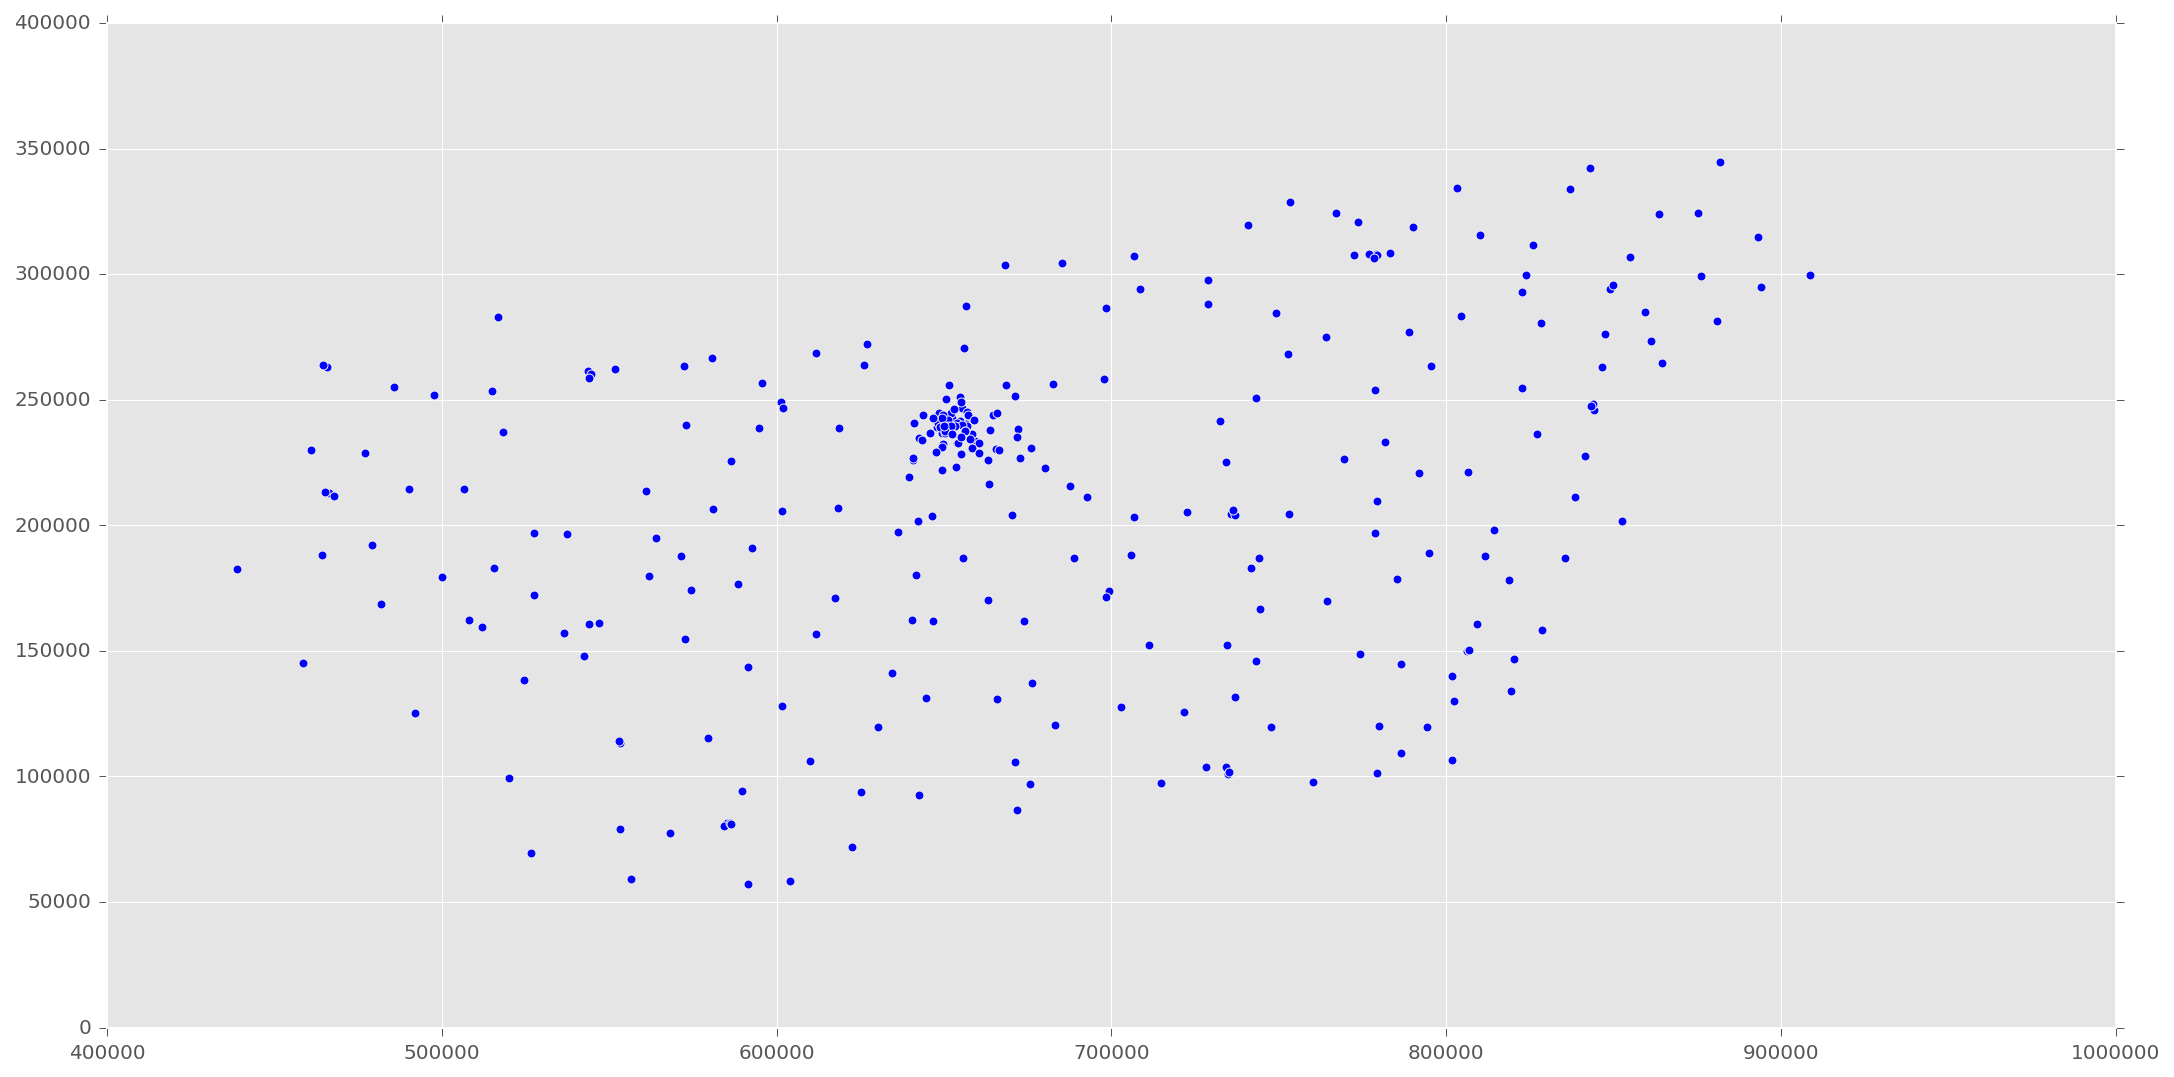

In [7]:
plt.scatter(poi["GEO_X"], poi["GEO_Y"])

# Train model

In [8]:
train_14.head()

,USER_ID,POI_ID,CHANNEL,DATE,TIME_CAT,LOC_CAT,MC_CAT,CARD_CAT,AMT_CAT,GEO_X,GEO_Y
0,91498,28052,p,2014-01-01,a,b,b,d,b,605119.0,58997.8
1,266177,1759,n,2014-01-01,a,NaN,j,d,b,NaN,NaN
2,202438,897,p,2014-01-01,a,b,b,d,c,698820.0,174757.0
3,109668,19939,p,2014-01-01,a,b,b,d,b,716050.0,271521.0
4,218581,13992,p,2014-01-01,a,a,j,d,c,653242.0,239511.0


In [9]:
# poi to bank pois distance
poi_to_idx = {k: v for v, k in enumerate(sorted(poi["POI_ID"]))}
poi2 = poi.copy()
poi2["POI_ID"] = poi2["POI_ID"].apply(poi_to_idx.get)
poi2 = poi2.sort_values("POI_ID")
poi2 = poi2[["GEO_X", "GEO_Y"]].as_matrix()

p_pois = pd.concat((
        train_14[train_14["CHANNEL"] == "p"][["POI_ID", "GEO_X", "GEO_Y"]].drop_duplicates(),
        train_15[train_15["CHANNEL"] == "p"][["POI_ID", "GEO_X", "GEO_Y"]].drop_duplicates()
    )).drop_duplicates()
p_pois_to_bank = dict(zip(p_pois.as_matrix()[:, 0], 
                     map(lambda x: np.argmin(np.linalg.norm(poi2 - x, axis=1)), p_pois.as_matrix()[:, 1:])
                 ))
len(p_pois_to_bank)

23199

In [10]:
def user_row_to_feat(row):
    
    def poi_distances_for_xy(x, y):
        return np.linalg.norm(poi2 - [x, y], axis=1)
    
    f = {}
    for k, v in dict(row).iteritems():
        if k in ["AGE_CAT", "LOC_CAT", "INC_CAT", "GEN", "LOC_GEO_X", "LOC_GEO_Y"]:
            f[k] = v
        if k[:3] in ("C20", "W20"):
            f[k[0] + k[-2:]] = v
    # make user features
    user_res = []
    user_res.extend(list(poi_distances_for_xy(f["LOC_GEO_X"], f["LOC_GEO_Y"])))
    
    # take C** and W** for months from utm
    tmpC = [0] * 6
    tmpW = [0] * 6
    for idx, m in enumerate(row["utm"][::-1]):
        m = m.split(".")[1]
        tmpC[-(idx + 1)] = f["C" + m]
        tmpW[-(idx + 1)] = f["W" + m]
    user_res.extend(tmpC + tmpW)
    user_res.append(f["GEN"])
    user_res.extend(list((np.array(["a", "b", "c"]) == f["AGE_CAT"]).astype(int)))
    user_res.extend(list((np.array(["a", "b", "c", "d"]) == f["INC_CAT"]).astype(int)))
    user_res.extend(list((np.array(["a", "b", "c"]) == f["LOC_CAT"]).astype(int)))
    return np.array([row["USER_ID"]] + user_res)
    
def users_to_features(users):
    res = parallel_apply_to_rows(
        users,
        user_row_to_feat,
        n_jobs=32
    )
    
    return {row[0]: row[1:] for row in res}

def user_trans_to_features(user_trans):
    
    def list_to_dict(lst):
        return {k: v for v, k in enumerate(lst)}

    fields_to_vals = {
        "TIME_CAT": ["a", "b", "c", ""],
        "LOC_CAT": ["a", "b", "c", ""],
        "MC_CAT": ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", ""],
        "CARD_CAT": ["c", "d", ""],
        "AMT_CAT": ["a", "b", "c", ""],
    }
    combs = [
        ["TIME_CAT"],
        ["LOC_CAT"],
        ["MC_CAT"],
        ["CARD_CAT"],
        ["AMT_CAT"],
        ["MC_CAT", "AMT_CAT"],
        ["LOC_CAT", "MC_CAT"],
        ["TIME_CAT", "LOC_CAT", "AMT_CAT"],
        ["CARD_CAT", "AMT_CAT"],
        ["MC_CAT", "CARD_CAT", "AMT_CAT"],
    ]
    combs_values_to_idx = []
    for comb in combs:
        combs_values_to_idx.append(list_to_dict(list(itertools.product(
                        *[fields_to_vals[feat] for feat in comb]))))
    res = []
    for comb, comb_vals in zip(combs, combs_values_to_idx):
        data = np.zeros((len(comb_vals),))
        for (_, row) in user_trans.iterrows():
            data[comb_vals[tuple("" if pd.isnull(row[f]) else row[f] for f in comb)]] = 1
        res.append(data)

    # transactions near bank poi
    data = np.zeros((len(poi),))
    for (_, row) in user_trans.iterrows():
        if row["CHANNEL"] == "p":
            data[p_pois_to_bank[row["POI_ID"]]] += 1
    res.append(data)
            
    return np.hstack(res)

def trans_to_users_features(transactions):
    return dict(
        parallel_groupby_and_apply(
            transactions[transactions["CHANNEL"].isin(["p", "n"])],
            "USER_ID",
            user_trans_to_features,
            n_jobs=32
        )
    )

def make_features(users, transactions, utm, target=None):
    # only for users in utm for respective months
    dates_df = []
    for uid, ms in utm.iteritems():
        start_y, start_m = ms[0].split(".")
        stop_y, stop_m = ms[-1].split(".")
        dates_df.append([uid, "{0}-{1}-01".format(start_y, start_m),"{0}-{1}-31".format(stop_y, stop_m)])
    dates_df = pd.DataFrame(dates_df, columns=["USER_ID", "start_date", "end_date"])
    transactions = transactions.merge(dates_df)
    transactions = transactions[(transactions["DATE"] >= transactions["start_date"]) &
                                (transactions["DATE"] <= transactions["end_date"])]

    utm_df = pd.DataFrame(list(utm.iteritems()), columns=["USER_ID", "utm"])
    users = users.merge(utm_df)
    
    users_f = users_to_features(users)
    trans_f = trans_to_users_features(transactions)
    
    X = []
    Y = []
    if target is not None:
        for uid in sorted(target.iterkeys()):
            X.append(np.hstack((
                        users_f[uid],
                        trans_f.get(uid, [0] * len(trans_f.itervalues().next())))
            ))
            Y.append(target[uid])
    else:
        for uid in sorted(users["USER_ID"]):
            X.append(np.hstack((
                        users_f[uid],
                        trans_f.get(uid, [0] * len(trans_f.itervalues().next())))
            ))
    
    X = np.array(X)
    Y = pd.DataFrame(Y).fillna(0).as_matrix()
    
    return X, Y

def make_target(transactions):
    TRAIN_SPLIT_DATE = '2014-06-30'
    
    df = transactions[transactions["DATE"] > TRAIN_SPLIT_DATE]
    
    df = df[df["CHANNEL"] == "b"]
    target = defaultdict(lambda: defaultdict(int))
    for (_, row) in df.iterrows():
        target[row["USER_ID"]][poi_to_idx[row["POI_ID"]]] += 1
    return target

In [11]:
%%time
target = make_target(train_14)

utm = {}
for uid in users_14["USER_ID"]:
    utm[uid] = ["2014.01", "2014.02", "2014.03", "2014.04", "2014.05", "2014.06"]

XX, YY = make_features(users_14, train_14, utm, target)

CPU times: user 1min 21s, sys: 9.12 s, total: 1min 30s
Wall time: 7min 24s


In [13]:
best_poi = np.argmax(YY, axis=1)
XX = np.concatenate((XX, XX[best_poi == 243])) # only one object
YY = np.concatenate((YY, YY[best_poi == 243]))
print XX.shape, YY.shape

(98994, 991) (98994, 323)


In [14]:
XX_1, XX_2, YY_1, YY_2 = train_test_split(XX, YY, test_size=0.10, random_state=42, stratify=np.argmax(YY, axis=1))

In [15]:
def eval_metric(y_true, y_pred):
    """
    y_true, y_pred: matrix users x pois with counts
    """
    scores = []
    for r_true, r_pred in zip(y_true, y_pred):
        r_true /= np.linalg.norm(r_true)
        sorted_idx = np.argsort(r_pred)[::-1]
        cosine_1 = r_true[sorted_idx[0]]
        pred_5_normalized = r_pred[sorted_idx[:5]]
        pred_5_normalized /= np.linalg.norm(pred_5_normalized)
        cosine_5 = np.dot(r_true[sorted_idx[:5]], pred_5_normalized)
        scores.append((cosine_1 + cosine_5) / 2.0)
    return np.mean(scores)

In [16]:
# Baseline (output closest pois with same values distribution as in target)
closest = np.argsort(-YY_1, axis=1)[:, :5]
thr = []
for idx in range(YY_1.shape[0]):
    thr.append(YY_1[idx][closest[idx]])
thr = np.mean(thr, axis=0)

closest = np.argsort(XX_2[:, :323], axis=1)[:, :5]
pred = np.zeros_like(YY_2)

for idx in range(YY_2.shape[0]):
    pred[idx][closest[idx]] = thr
print eval_metric(YY_2, pred)

0.577780375194


In [ ]:
%%time
classifier_per_class = []
for class_idx in range(YY.shape[1]):
    clf = xgb.XGBClassifier(n_estimators=75)
    y = (YY_1[:, class_idx] > 0).astype(int)
    clf.fit(XX_1, y)
    classifier_per_class.append(clf)
    print class_idx, "done"

0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
51 done
52 done
53 done
54 done
55 done
56 done
57 done
58 done
59 done
60 done
61 done
62 done
63 done
64 done
65 done
66 done
67 done
68 done
69 done
70 done
71 done
72 done
73 done
74 done
75 done
76 done
77 done
78 done
79 done
80 done
81 done
82 done
83 done
84 done
85 done
86 done
87 done
88 done
89 done
90 done
91 done
92 done
93 done
94 done
95 done
96 done
97 done
98 done
99 done
100 done
101 done
102 done
103 done
104 done
105 done
106 done
107 done
108 done
109 done
110 done
111 done
112 done
113 done
114 done
115 done
116 done
117 done
118 done
119 done
120 done
121 done
122 done
123

In [19]:
np.save("classifier_per_class.npy", classifier_per_class)
classifier_per_class = np.load("classifier_per_class.npy")

In [20]:
# predict probas for train and test
def predict_proba_for_clf(clf, x):
    return clf.predict_proba(x)[:, 1]

pred_first_proba_tr = Parallel(n_jobs=32, backend="threading")(
    delayed(predict_proba_for_clf)(clf, XX_1)
    for clf in classifier_per_class
)
pred_first_proba_tr = np.vstack(pred_first_proba_tr).T

pred_first_proba = Parallel(n_jobs=32, backend="threading")(
    delayed(predict_proba_for_clf)(clf, XX_2)
    for clf in classifier_per_class
)
pred_first_proba = np.vstack(pred_first_proba).T

In [23]:
# evaluate on test
pred2 = pred_first_proba.copy()
closest = np.argsort(-pred2, axis=1)[:, :5]
pred3 = np.zeros_like(YY_2)
for idx in range(YY_2.shape[0]):
    vals = pred2[idx][closest[idx]]
    pred3[idx][closest[idx]] = vals
print eval_metric(YY_2, pred3)

# 0.679382259127 -> 0.6818
# 0.680437368829 -> 0.6843
# 0.682123092701 -> 0.6849
# 0.683509285526 -> 0.6851

0.682123092701


In [137]:
# hack (boost pois based on top 1 distribution in train)
pred_first_proba2 = pred_first_proba.copy()
cnt = Counter(np.argmax(YY_1, axis=1))
cnt = {k: v / float(len(YY_1)) for k, v in cnt.items()}
for poi_idx, rat in cnt.iteritems():
    t = np.sort(pred_first_proba[:, poi_idx])[::-1][int(rat * len(YY_2))]
    pred_first_proba2[pred_first_proba[:, poi_idx] > t * 1.5, poi_idx] *= 1.5
eval_metric(YY_2, pred_first_proba2)

0.683509285526404

# Submission

In [34]:
%%time
utm = {}
for uid in users_15["USER_ID"]:
    utm[uid] = ["2015.01", "2015.02", "2015.03", "2015.04", "2015.05", "2015.06"]
XXX, _ = make_features(users_15, train_15, utm)

CPU times: user 43.7 s, sys: 15.4 s, total: 59.1 s
Wall time: 7min 41s


In [83]:
def predict_proba_for_clf(clf, x):
    return clf.predict_proba(x)[:, 1]
pred_first_proba_te = Parallel(n_jobs=32, backend="threading")(
    delayed(predict_proba_for_clf)(clf, XXX)
    for clf in classifier_per_class
)
pred_first_proba_te = np.vstack(pred_first_proba_te).T

In [150]:
pred_first_proba2 = pred_first_proba_te.copy()
cnt = Counter(np.argmax(YY_1, axis=1))
cnt = {k: v / float(len(YY_1)) for k, v in cnt.items()}
for poi_idx, rat in cnt.iteritems():
    t = np.sort(pred_first_proba_te[:, poi_idx])[::-1][int(rat * len(XXX))]
    pred_first_proba2[pred_first_proba_te[:, poi_idx] > t * 1.5, poi_idx] *= 1.5

In [151]:
pred2 = pred_first_proba2.copy()
closest = np.argsort(-pred2, axis=1)[:, :5]
bla_pred = []
for idx in range(XXX.shape[0]):
    bla_pred.append(pred2[idx, closest[idx]])
bla_pred = np.vstack(bla_pred)

In [152]:
idx_to_poi = {v: k for v, k in enumerate(sorted(poi["POI_ID"]))}

with open("submission.csv", "w") as f:
    f.write("#USER_ID,POI_ID,NUMBER_OF_VISITS\n")
    for uid, idxs, vals in zip(sorted(users_15["USER_ID"]), closest, bla_pred):
        f.write("\n".join("{0},{1},{2}".format(uid, int(idx_to_poi[i]), w) for i, w in zip(idxs, vals)) + "\n")

In [154]:
! head submission.csv

#USER_ID,POI_ID,NUMBER_OF_VISITS
1,22537,0.804153621197
1,395,0.193244621158
1,8068,0.0168208219111
1,17563,0.00891651026905
1,17763,0.00818252470344
2,28442,1.35502851009
2,8716,0.0365627631545
2,16688,0.0146398488432
2,22467,0.0103691983968
